# 0. Prepare

In [1]:
import random
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [15, 10]

from tqdm import tqdm
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Setting

In [2]:
CFG = {
    'N_SPLITS':5,
    'THRESHOLD':0.5,
    'SEED':41
}
AMINO_LIST = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
PH_RANGE = range(1, 10, 2)

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(CFG['SEED']) # Seed 고정

# 1. Preprocessing

## 1-0. 불필요한 Column 설정

In [4]:
useless_columns = [
'id', 
'antigen_code',
'number_of_tested',
'number_of_responses',
# 'reference_date',
'reference_IRI',
'reference_journal',
# 'assay_method_technique',
# 'assay_group',
# 'disease_type',
# 'disease_state',
# 'reference_title',
# 'epitope_aromaticity',
# 'epitope_gravy',
# 'epitope_instability_index',
# 'epitope_isoelectric_point',
# 'epitope_length',
# 'epitope_molecular_weight',
# 'epitope_monoisotopic',
]
useless_columns += ['epitope_molar_extinction_coefficient_' + v for v in ['cysteines', 'cystines']] #
useless_columns += ['epitope_secondary_structure_fraction_' + v for v in ['helix', 'turn', 'sheet']] ####
useless_columns += ['epitope_charge_at_pH_' + v for v in ['1', '3', '5', '7', '9']]
useless_columns += ['epitope_count_amino_acids_' + v for v in AMINO_LIST] #
useless_columns += ['epitope_get_amino_acids_percent_' + v for v in AMINO_LIST] #
useless_columns += [
# 'antigen_aromaticity',
# 'antigen_gravy',
# 'antigen_instability_index',
# 'antigen_isoelectric_point',
'antigen_length',
# 'antigen_molecular_weight',
# 'antigen_monoisotopic',
]
useless_columns += ['antigen_molar_extinction_coefficient_' + v for v in ['cysteines', 'cystines']] #
useless_columns += ['antigen_secondary_structure_fraction_' + v for v in ['helix', 'turn', 'sheet']] ####
useless_columns += ['antigen_charge_at_pH_' + v for v in ['1', '3', '5', '7', '9']]
useless_columns += ['antigen_count_amino_acids_' + v for v in AMINO_LIST] #
useless_columns += ['antigen_get_amino_acids_percent_' + v for v in AMINO_LIST] #

## 1-1. Epitope&Antigen information Preprocessing(train_preprocessed.csv 1번 생성 이후 생략 가능)

In [5]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

def get_amino_features(seq):
    f = ProteinAnalysis(seq)
    new_col = [f.aromaticity(), f.gravy(), f.instability_index(), f.isoelectric_point(), f.length, f.molecular_weight(), f.monoisotopic]
    
    f_cysteines, f_cystines = f.molar_extinction_coefficient()
    new_col += [f_cysteines, f_cysteines]
    
    f_helix, f_turn, f_sheet = f.secondary_structure_fraction()
    new_col += [f_helix, f_turn, f_sheet]
    
    #f.features.flexibility()
    #f.protein_scale()
    
    new_col += [f.charge_at_pH(ph) for ph in PH_RANGE]
    
    f_amino_cnt = f.count_amino_acids()
    new_col += [f_amino_cnt[alpha] for alpha in AMINO_LIST]
    
    f_amino_per = f.get_amino_acids_percent()
    new_col += [f_amino_per[alpha] for alpha in AMINO_LIST]
    
    return new_col
    
def preprocess_df(df):
    # amino features
    new_cols = []
    for k in ['epitope', 'antigen']:
        tqdm.pandas()
        new_arr = df.progress_apply(lambda row: get_amino_features(row[k+'_seq']), axis=1)
        
        new_key = [k+'_aromaticity', k+'_gravy', k+'_instability_index', k+'_isoelectric_point', k+'_length', k+'_molecular_weight', k+'_monoisotopic']
        new_key += [k+'_molar_extinction_coefficient_cysteines', k+'_molar_extinction_coefficient_cystines']
        new_key += [k+'_secondary_structure_fraction_helix', k+'_secondary_structure_fraction_turn', k+'_secondary_structure_fraction_sheet']
        new_key += [k+'_charge_at_pH_'+str(ph) for ph in PH_RANGE]
        new_key += [k+'_count_amino_acids_'+alpha for alpha in AMINO_LIST]
        new_key += [k+'_get_amino_acids_percent_'+alpha for alpha in AMINO_LIST]
        
        df_new = pd.DataFrame(new_arr.values.tolist(), columns=new_key)
        new_cols.append(df_new)
        print('Done', k, 'sequence.')
    
    # Table features
    df = df.drop(['epitope_seq', 'antigen_seq', 'start_position', 'end_position'], axis=1)
    df = pd.concat([df]+new_cols, axis=1)
    # One-hot encoding
    
    return df

In [6]:
# train
df = pd.read_csv('./data/train.csv')
df = preprocess_df(df)

100%|██████████| 190811/190811 [00:56<00:00, 3367.64it/s]


Done epitope sequence.


100%|██████████| 190811/190811 [05:34<00:00, 570.71it/s] 


Done antigen sequence.


In [7]:
# Save Preprocessed Data
df.to_csv('./data/train_preprocessed.csv', index=False)

## 1-2. Read Preprocessed Data & Remove useless columns

In [5]:
# Read preprocessed Data
df = pd.read_csv('./data/train_preprocessed.csv')

In [6]:
df = df.drop(useless_columns+['qualitative_label'], axis=1)

## 1-3. One-hot Encoding

In [7]:
# One-hot Encoding
df = pd.get_dummies(df) ### skip if catboost
train_cols = df.columns

In [8]:
df

,reference_date,label,epitope_aromaticity,epitope_gravy,epitope_instability_index,epitope_isoelectric_point,epitope_length,epitope_molecular_weight,epitope_monoisotopic,antigen_aromaticity,...,reference_title_Viral suppression function of intracellular antibody against C-terminal domain of rabies virus phosphoprotein.,"reference_title_Virus isolate-specific antibodies against hypervariable region 1 of the hepatitis C virus second envelope protein, gp70.","reference_title_Walnut allergy in peanut-allergic patients: significance of sequential epitopes of walnut homologous to linear epitopes of Ara h 1, 2 and 3 in relation to clinical reactivity.",reference_title_What Characteristics Confer Proteins the Ability to Induce Allergic Responses? IgE Epitope Mapping and Comparison of the Structure of Soybean 2S Albumins and Ara h 2.,reference_title_Whole CMV proteome pattern recognition analysis after HSCT identifies unique epitope targets associated with the CMV status.,reference_title_Whole-Proteome Peptide Microarrays for Profiling Autoantibody Repertoires within Multiple Sclerosis and Narcolepsy.,reference_title_ZIKV-Specific NS1 Epitopes as Serological Markers of Acute Zika Virus Infection.,"reference_title_Zinc ion dependent B-cell epitope, associated with primary Sjogren's syndrome, resides within the putative zinc finger domain of Ro60kD autoantigen: physical and immunologic properties.",reference_title_and Evaluation of Mimetic Peptides as Potential Antigen Candidates for Prophylaxis of Leishmaniosis.,"reference_title_p185, an immunodominant epitope, is an autoantigen mimotope."
0,1976,1,0.000000,-0.050000,12.133333,8.750052,6,630.7340,False,0.115044,...,0,0,0,0,0,0,0,0,0,0
1,1976,1,0.000000,-0.900000,-19.966667,5.552794,6,646.6904,False,0.115044,...,0,0,0,0,0,0,0,0,0,0
2,1976,1,0.166667,-0.450000,32.050417,4.050028,24,2610.7345,False,0.115044,...,0,0,0,0,0,0,0,0,0,0
3,1976,1,0.375000,-0.925000,89.001250,4.050028,8,978.9535,False,0.115044,...,0,0,0,0,0,0,0,0,0,0
4,1976,1,0.333333,-1.566667,94.768333,4.050028,6,744.7024,False,0.115044,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190806,2022,0,0.058824,-1.379412,69.908824,8.900715,34,4047.5009,False,0.058140,...,0,0,0,0,0,0,0,0,0,0
190807,2022,1,0.000000,-1.270833,94.458333,5.062899,24,2895.2367,False,0.058140,...,0,0,0,0,0,0,0,0,0,0
190808,2022,1,0.102041,-2.016327,80.320408,4.451084,49,5710.8054,False,0.070064,...,0,0,0,0,0,0,0,0,0,0
190809,2022,1,0.031250,-1.465625,75.540625,8.954739,32,3979.4932,False,0.058140,...,0,0,0,0,0,0,0,0,0,0


# 2. Train Random Forest Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold

def eval_classification(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy  = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    f1        = f1_score(y_test, pred, average='macro')
    print('Confusion Matrix')
    print(confusion)
    print(f'Accuracy:{accuracy:.6f}, Precision:{precision:.6f}, Recall:{recall:.6f}, F1:{f1:.6f}')
    return accuracy, precision, recall, f1

def threshold_eval(model, x, y):
    for th in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8]:
        print('THRESHOLD:', th)
        #idx = np.where((pred_p[:,1] >= 0.7))
        pred_p = model.predict_proba(x) ###
        pred = np.where(pred_p[:,1] >= th, 1, 0)
        eval_classification(y, pred)

In [10]:
f1s = []
preds = []
models = []
kf = KFold(n_splits=CFG['N_SPLITS'], random_state=CFG['SEED'], shuffle=True)
for i, (train_idx, val_idx) in enumerate(kf.split(df)):
    # splitted Data
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_x = train_df.drop(['label'], axis=1)
    train_y = train_df['label'].values

    val_x = val_df.drop(['label'], axis=1)
    val_y = val_df['label'].values
    #print(len(train_x), len(val_x))
    
    # Model
    model_rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=random.randrange(100)
    )

    #%%time
    model_rf.fit(train_x, train_y)
    #pred = model_rf.predict(val_x) ###
    pred_prob = model_rf.predict_proba(val_x)[:,1] ###
    pred = pred_prob >= CFG['THRESHOLD']
    accuracy, precision, recall, f1 = eval_classification(val_y, pred)
    f1s.append(f1)
    preds.append(pred_prob)
    models.append(model_rf)

Confusion Matrix
[[34268   469]
 [ 1104  2322]]
Accuracy:0.958782, Precision:0.831960, Recall:0.677758, F1:0.862274
Confusion Matrix
[[34269   531]
 [ 1026  2336]]
Accuracy:0.959200, Precision:0.814789, Recall:0.694825, F1:0.863914
Confusion Matrix
[[34373   462]
 [ 1054  2273]]
Accuracy:0.960275, Precision:0.831079, Recall:0.683198, F1:0.864171
Confusion Matrix
[[34274   458]
 [ 1121  2309]]
Accuracy:0.958624, Precision:0.834478, Recall:0.673178, F1:0.861341
Confusion Matrix
[[34362   493]
 [ 1049  2258]]
Accuracy:0.959593, Precision:0.820792, Recall:0.682794, F1:0.861758


In [11]:
#threshold_eval(models[0], val_x, val_y)

In [12]:
# Save Model
with open('models.pickle', 'wb') as f:
    pickle.dump({'models': models, 'columns':train_cols}, f, pickle.HIGHEST_PROTOCOL)

## 2-1. Feature Importance

In [13]:
# Calcualte mean of each feature importance
feature_importances = []
for model in models:
    feature_importances.append(model.feature_importances_)
feature_importances = np.array(feature_importances).mean(axis=0)

In [14]:
topk = 50
top_feats = np.argsort(feature_importances)[:-topk-1:-1]

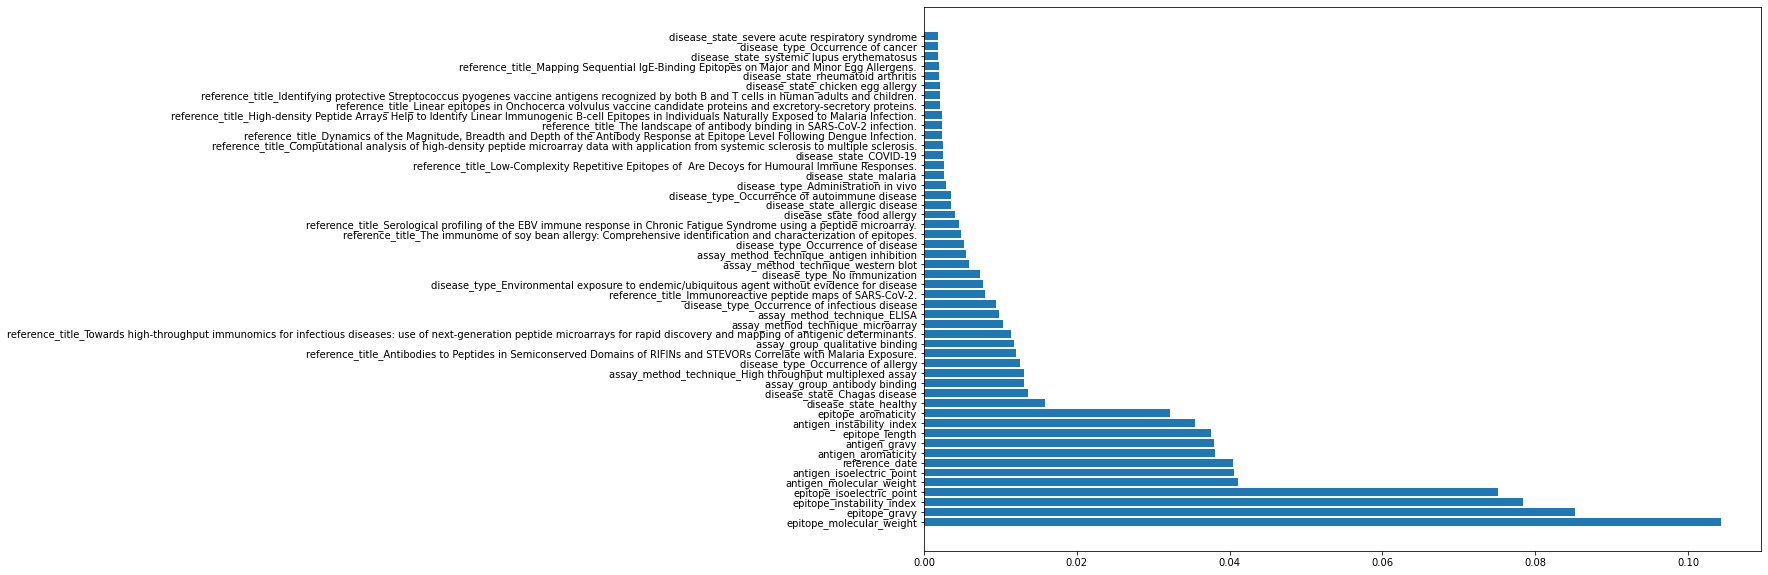

In [15]:
plt.barh(train_x.columns[top_feats], feature_importances[top_feats])
plt.show()

# 3. Inference(test)

## 3-0. Test Data preprocessing

In [19]:
# Preprocessing (skippable)
test_df = pd.read_csv('./data/test.csv')
test_df = preprocess_df(test_df)

test_df.to_csv('./data/test_preprocessed.csv', index=False)

100%|██████████| 120944/120944 [00:35<00:00, 3376.13it/s]


Done epitope sequence.


100%|██████████| 120944/120944 [24:32<00:00, 82.12it/s] 


Done antigen sequence.


## 3-1. Load Preprocessed test data

In [16]:
# Load Models
with open('models.pickle', 'rb') as f:
    p = pickle.load(f)
models = p['models']
train_cols = p['columns']

In [17]:
# Load Data
test_df = pd.read_csv('./data/test_preprocessed.csv')
test_df = test_df.drop(useless_columns, axis=1)
test_df = pd.get_dummies(test_df) 

In [18]:
# One-hot Encoding
inter_cols = train_cols.intersection(test_df.columns)
test_x = pd.DataFrame(0, index=test_df.index, columns=train_cols).drop(['label'], axis=1)
test_x[inter_cols] = test_df[inter_cols]

In [19]:
test_x

,reference_date,epitope_aromaticity,epitope_gravy,epitope_instability_index,epitope_isoelectric_point,epitope_length,epitope_molecular_weight,epitope_monoisotopic,antigen_aromaticity,antigen_gravy,...,reference_title_Viral suppression function of intracellular antibody against C-terminal domain of rabies virus phosphoprotein.,"reference_title_Virus isolate-specific antibodies against hypervariable region 1 of the hepatitis C virus second envelope protein, gp70.","reference_title_Walnut allergy in peanut-allergic patients: significance of sequential epitopes of walnut homologous to linear epitopes of Ara h 1, 2 and 3 in relation to clinical reactivity.",reference_title_What Characteristics Confer Proteins the Ability to Induce Allergic Responses? IgE Epitope Mapping and Comparison of the Structure of Soybean 2S Albumins and Ara h 2.,reference_title_Whole CMV proteome pattern recognition analysis after HSCT identifies unique epitope targets associated with the CMV status.,reference_title_Whole-Proteome Peptide Microarrays for Profiling Autoantibody Repertoires within Multiple Sclerosis and Narcolepsy.,reference_title_ZIKV-Specific NS1 Epitopes as Serological Markers of Acute Zika Virus Infection.,"reference_title_Zinc ion dependent B-cell epitope, associated with primary Sjogren's syndrome, resides within the putative zinc finger domain of Ro60kD autoantigen: physical and immunologic properties.",reference_title_and Evaluation of Mimetic Peptides as Potential Antigen Candidates for Prophylaxis of Leishmaniosis.,"reference_title_p185, an immunodominant epitope, is an autoantigen mimotope."
0,2021,0.125000,-0.912500,68.862500,6.133916,16,1766.8797,False,0.107384,-0.070138,...,0,0,0,0,0,0,0,0,0,0
1,2015,0.066667,0.586667,71.486667,4.050028,15,1563.7699,False,0.066879,-0.211783,...,0,0,0,0,0,0,0,0,0,0
2,2021,0.083333,-0.716667,38.841667,8.750052,12,1255.3573,False,0.124164,-0.122007,...,0,0,0,0,0,0,0,0,0,0
3,2021,0.083333,0.208333,38.708333,5.056761,12,1243.3250,False,0.122763,0.065624,...,0,0,0,0,0,0,0,0,0,0
4,2021,0.000000,-0.150000,93.041667,4.050028,12,1367.4760,False,0.097901,-0.019124,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120939,2015,0.133333,-0.666667,99.133333,4.118235,15,1839.9916,False,0.024235,-1.228168,...,0,0,0,0,0,0,0,0,0,0
120940,2021,0.083333,0.233333,46.100000,4.050028,12,1349.5084,False,0.107092,-0.021177,...,0,0,0,0,0,0,0,0,0,0
120941,2021,0.062500,0.343750,52.025000,4.137447,16,1764.0048,False,0.103492,-0.070663,...,0,0,0,0,0,0,0,0,0,0
120942,2015,0.133333,-0.520000,31.900000,11.263868,15,1802.1934,False,0.086164,-0.392626,...,0,0,0,0,0,0,0,0,0,0


## 3-2. Inference

In [20]:
preds = []
for model_rf in models:
    pred_prob = model_rf.predict_proba(test_x)[:,1] ###
    preds.append(pred_prob)
preds = np.array(preds)

In [21]:
#pred = model_rf.predict(test_x) ###
pred = preds.mean(axis=0) >= 0.5 # CFG['THRESHOLD']
len(pred), pred.sum()

(120944, 11912)

In [22]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['label'] = pred.astype(np.int32)
#submit['1'] = pred[:,1].astype(np.float32)

In [23]:
submit.to_csv('./submit.csv', index=False)
print('Done.')

Done.
